# Compare Results

Short idea: load metrics from `data/results/` and compare FLAML / TPOT / auto-sklearn with tables and plots.

## AutoML

Plot RMSE vs iteration for the 4 models from an AutoML `state_matrix.json`. The line is highlighted (thicker) while a model is the one being explored (`current_model=True`).

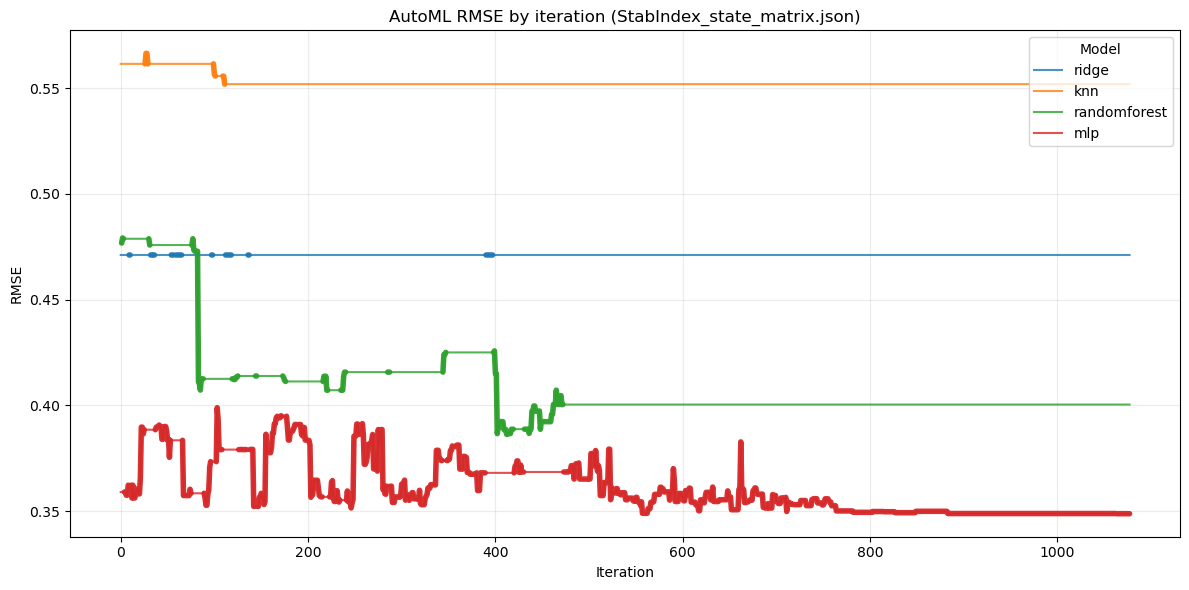

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Change this file to inspect a different AutoML run
state_matrix_path = Path("../data/results/automl/StabIndex_state_matrix.json")

with state_matrix_path.open("r", encoding="utf-8") as f:
    state_matrix = json.load(f)

rows = []
for iter_key, iter_state in state_matrix.items():
    iter_idx = int(iter_key)
    for model_name, model_state in iter_state.items():
        rows.append({
            "iter": iter_idx,
            "model": model_name,
            "rmse": float(model_state["rmse"]),
            "current_model": bool(model_state.get("current_model", False)),
        })

df = pd.DataFrame(rows).sort_values(["iter", "model"]).reset_index(drop=True)
model_order = [m for m in ["ridge", "knn", "randomforest", "mlp"] if m in df["model"].unique()]
colors = {
    "ridge": "#1f77b4",
    "knn": "#ff7f0e",
    "randomforest": "#2ca02c",
    "mlp": "#d62728",
}

fig, ax = plt.subplots(figsize=(12, 6))

for model_name in model_order:
    d = df[df["model"] == model_name].sort_values("iter").copy()
    c = colors.get(model_name, None)

    # Base trajectory (always visible)
    ax.plot(
        d["iter"],
        d["rmse"],
        label=model_name,
        color=c,
        linewidth=1.5,
        alpha=0.8,
    )

    # Highlight only the iterations where this model is the active/current one
    y_highlight = d["rmse"].where(d["current_model"], np.nan)
    ax.plot(
        d["iter"],
        y_highlight,
        color=c,
        linewidth=4.0,
        alpha=0.95,
        solid_capstyle="round",
    )

ax.set_title(f"AutoML RMSE by iteration ({state_matrix_path.name})")
ax.set_xlabel("Iteration")
ax.set_ylabel("RMSE")
ax.grid(True, alpha=0.25)
ax.legend(title="Model")
plt.tight_layout()
plt.show()